In [1]:
import py2neo

Right we're going to use some of the graph based features as predictors

First let's decide what we want to predict

We have:
Nodes: Compound, Fragment
Edges: IS_FRAGMENT_MMP_OF, IS_FRAGMENT_OF, IS_MMP_OF

We could predict several things:

### 1) Given a Compound predict the property:
   Properties: fragments encoded as word to vec, MMP as word to vec
   
### 2) Given:
        - A starting fragment
        - A desired property delta
    Then: Predict the next fragment and the new property value? (as in the change)
    Features:
        - Fingerprint
        - Radius? (or select a radius and learn a model per radius)
        - Degree
        - Betweeness
3) Given a Fragment-Fragment pair (and environment ID - cat?) predict the property delta
    - Boolean (positive or negative), multiclass -2, -1, 0, 1, 2
4) We have a graph can we predict new edges?

In [2]:
from py2neo import Graph
graph_1 = Graph(host="localhost", password='mmpkg')

### Create in-memory graphs

In [50]:
#Create a graph for running compound similarity based on fragments with
graph_1.run("""
            CALL gds.graph.create('fragsimgraph', ['Compound', 'Fragment'], 'IS_FRAGMENT_OF')
            """).data()

[{'graphName': 'fragsimgraph2',
  'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'},
   'Compound': {'properties': {}, 'label': 'Compound'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {}}},
  'nodeCount': 3433,
  'relationshipCount': 5047,
  'createMillis': 18}]

In [55]:
#Create a graph for running compound similarity based on fragments with
graph_1.run("""
            CALL gds.graph.create('fragsimgraph_c', ['Fragment', 'Compound'], 
            {IS_FRAGMENT_OF: {
                    type: 'IS_FRAGMENT_OF',
                    orientation: 'REVERSE'
            }})
            """).data()

[{'graphName': 'fragsimgraph_c',
  'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'},
   'Compound': {'properties': {}, 'label': 'Compound'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'REVERSE',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {}}},
  'nodeCount': 3433,
  'relationshipCount': 5047,
  'createMillis': 11}]

In [113]:
#Create a graph for runn
graph_1.run("""
            CALL gds.graph.create('compgraph', ['Compound'],'IS_FRAGMENT_OF')
            """).data()

[{'graphName': 'compgraph3',
  'nodeProjection': {'Compound': {'properties': {}, 'label': 'Compound'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {}}},
  'nodeCount': 965,
  'relationshipCount': 0,
  'createMillis': 9}]

In [304]:
#Create a graph for looking at how fragments have influence in the graph 
graph_1.run("""
            CALL gds.graph.create('fraggraph', ['Fragment'],['IS_FRAGMENT_OF','MMP_RULE_ENVIRONMENT'],
            {relationshipProperties:['avg']})
            """).data()

[{'graphName': 'fraggraph',
  'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {'avg': {'property': 'avg',
      'defaultValue': nan,
      'aggregation': 'DEFAULT'}}},
   'MMP_RULE_ENVIRONMENT': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'MMP_RULE_ENVIRONMENT',
    'properties': {'avg': {'property': 'avg',
      'defaultValue': nan,
      'aggregation': 'DEFAULT'}}}},
  'nodeCount': 2468,
  'relationshipCount': 31679,
  'createMillis': 155}]

In [69]:
#Create a graph for looking at how fragments have influence in the graph 
graph_1.run("""
            CALL gds.graph.create('fraggraph_2', ['Fragment'],['MMP_RULE_ENVIRONMENT'],
            {relationshipProperties:['avg']})
            """).data()

[{'graphName': 'fraggraph_2',
  'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'}},
  'relationshipProjection': {'MMP_RULE_ENVIRONMENT': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'MMP_RULE_ENVIRONMENT',
    'properties': {'avg': {'property': 'avg',
      'defaultValue': nan,
      'aggregation': 'DEFAULT'}}}},
  'nodeCount': 2468,
  'relationshipCount': 31679,
  'createMillis': 37}]

### Graph Maintainance

In [70]:
#Clean up shit
pd.DataFrame(graph_1.run("""
            CALL gds.graph.list()
            """).data())

,degreeDistribution,graphName,nodeCount,nodeProjection,nodeQuery,relationshipCount,relationshipProjection,relationshipQuery
0,"{'p99': 114, 'min': 0, 'max': 677, 'mean': 12....",fraggraph,2468,"{'Fragment': {'properties': {}, 'label': 'Frag...",None,31679,"{'IS_FRAGMENT_OF': {'orientation': 'NATURAL', ...",None
1,"{'p99': 12, 'min': 0, 'max': 142, 'mean': 1.47...",fragsimgraph_c,3433,"{'Fragment': {'properties': {}, 'label': 'Frag...",None,5047,"{'IS_FRAGMENT_OF': {'orientation': 'REVERSE', ...",None
2,"{'p99': 16, 'min': 0, 'max': 36, 'mean': 1.470...",fragsimgraph,3433,"{'Fragment': {'properties': {}, 'label': 'Frag...",None,5047,"{'IS_FRAGMENT_OF': {'orientation': 'NATURAL', ...",None
3,"{'p99': 114, 'min': 0, 'max': 677, 'mean': 12....",fraggraph_2,2468,"{'Fragment': {'properties': {}, 'label': 'Frag...",None,31679,{'MMP_RULE_ENVIRONMENT': {'orientation': 'NATU...,None


In [53]:
#Clean up shit
graph_1.run("""
            CALL gds.graph.drop('fragsimgraph_c')
            """).data()

[{'graphName': 'fragsimgraph_c',
  'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'},
   'Compound': {'properties': {}, 'label': 'Compound'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {}}},
  'nodeQuery': None,
  'relationshipQuery': None,
  'nodeCount': 3433,
  'relationshipCount': 5047,
  'degreeDistribution': {'p99': 16,
   'min': 0,
   'max': 36,
   'mean': 1.4701427323041072,
   'p90': 5,
   'p50': 0,
   'p999': 32,
   'p95': 9,
   'p75': 1}}]

### Node Similarity

In [17]:
data = graph_1.run("""
            CALL gds.nodeSimilarity.stream('fragsimgraph')
            YIELD node1, node2, similarity
            RETURN gds.util.asNode(node1).smiles AS Compound1, gds.util.asNode(node2).smiles AS Compound2, gds.util.asNode(node1).compoundid, gds.util.asNode(node2).compoundid, similarity
            ORDER BY similarity DESCENDING, Compound1, Compound2
            """).data()

In [5]:
data = graph_1.run("""
                CALL gds.nodeSimilarity.write('fragsimgraph',
                {
                writeRelationshipType: 'SIMILAR_BY_FRAGMENT',
                writeProperty: 'similarity_score'
                })
                YIELD nodesCompared, relationshipsWritten
                """).data()

In [9]:
data

[{'Compound1': 'CC#Cc1cncc(-c2cccc([C@@]3(c4cc(C)c(=O)n(CC)c4)N=C(N)c4c(F)cccc43)c2)c1',
  'Compound2': 'CC#Cc1cncc(-c2csc([C@]3(C)CC(=O)N(C)C(=N)N3)c2)c1',
  'gds.util.asNode(node1).compoundid': '929',
  'gds.util.asNode(node2).compoundid': '950',
  'similarity': 1.0},
 {'Compound1': 'CC#Cc1cncc(-c2csc([C@]3(C)CC(=O)N(C)C(=N)N3)c2)c1',
  'Compound2': 'CC#Cc1cncc(-c2cccc([C@@]3(c4cc(C)c(=O)n(CC)c4)N=C(N)c4c(F)cccc43)c2)c1',
  'gds.util.asNode(node1).compoundid': '950',
  'gds.util.asNode(node2).compoundid': '929',
  'similarity': 1.0},
 {'Compound1': 'CC(=O)N[C@H](C)c1ccc(Nc2ncc3cc(-c4ccncc4)c(C)cc3n2)cc1',
  'Compound2': 'COc1ccc2c(C)cc(=O)n(CCN3CCC(NCc4cc5c(cn4)OCCO5)CC3)c2c1',
  'gds.util.asNode(node1).compoundid': '871',
  'gds.util.asNode(node2).compoundid': '856',
  'similarity': 1.0},
 {'Compound1': 'CC(=O)N[C@H](C)c1ccc(Nc2ncc3cc(-c4ccncc4)c(C)cc3n2)cc1',
  'Compound2': 'Cc1cc2cc(C)c3nnc(SCC(=O)N4CCN(C(=O)c5ccco5)CC4)n3c2cc1C',
  'gds.util.asNode(node1).compoundid': '871',
  'g

In [10]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from IPython.core.display import display, HTML
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.ipython_useSVG = True

In [18]:
df = pd.DataFrame(data)
PandasTools.AddMoleculeColumnToFrame(df, 'Compound1','Compound1')
PandasTools.AddMoleculeColumnToFrame(df, 'Compound2','Compound2')

In [101]:
data

[{'Compound1': 'CC#Cc1cncc(-c2cccc([C@@]3(c4cc(C)c(=O)n(CC)c4)N=C(N)c4c(F)cccc43)c2)c1',
  'Compound2': 'CC#Cc1cncc(-c2csc([C@]3(C)CC(=O)N(C)C(=N)N3)c2)c1',
  'gds.util.asNode(node1).compoundid': '929',
  'gds.util.asNode(node2).compoundid': '950',
  'similarity': 1.0},
 {'Compound1': 'CC#Cc1cncc(-c2csc([C@]3(C)CC(=O)N(C)C(=N)N3)c2)c1',
  'Compound2': 'CC#Cc1cncc(-c2cccc([C@@]3(c4cc(C)c(=O)n(CC)c4)N=C(N)c4c(F)cccc43)c2)c1',
  'gds.util.asNode(node1).compoundid': '950',
  'gds.util.asNode(node2).compoundid': '929',
  'similarity': 1.0},
 {'Compound1': 'CC(=O)N[C@H](C)c1ccc(Nc2ncc3cc(-c4ccncc4)c(C)cc3n2)cc1',
  'Compound2': 'COc1ccc2c(C)cc(=O)n(CCN3CCC(NCc4cc5c(cn4)OCCO5)CC3)c2c1',
  'gds.util.asNode(node1).compoundid': '871',
  'gds.util.asNode(node2).compoundid': '856',
  'similarity': 1.0},
 {'Compound1': 'CC(=O)N[C@H](C)c1ccc(Nc2ncc3cc(-c4ccncc4)c(C)cc3n2)cc1',
  'Compound2': 'Cc1cc2cc(C)c3nnc(SCC(=O)N4CCN(C(=O)c5ccco5)CC4)n3c2cc1C',
  'gds.util.asNode(node1).compoundid': '871',
  'g

,Compound1,Compound2,frag_deg_1,frag_deg_2,gds.util.asNode(node1).compoundid,gds.util.asNode(node2).compoundid,similarity
0,,,1.0,1.0,929,950,1.000000
1,,,1.0,1.0,950,929,1.000000
2,,,1.0,1.0,871,856,1.000000
3,,,1.0,1.0,871,869,1.000000
4,,,3.0,3.0,578,580,1.000000
5,,,1.0,1.0,916,932,1.000000
6,,,2.0,2.0,859,496,1.000000
7,,,2.0,2.0,859,836,1.000000
8,,,2.0,2.0,859,494,1.000000
9,,,2.0,2.0,30,838,1.000000

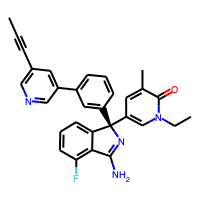
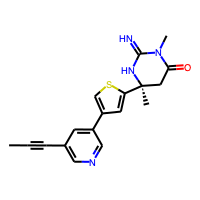
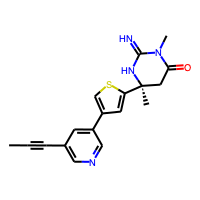
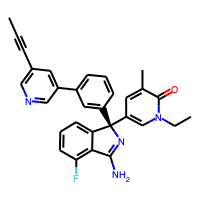
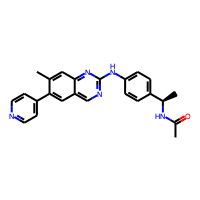
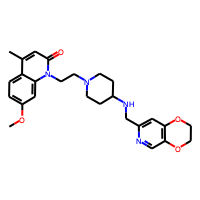
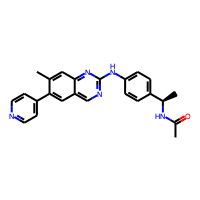
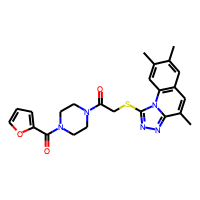
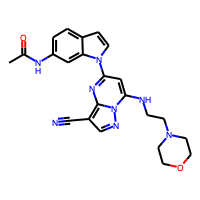
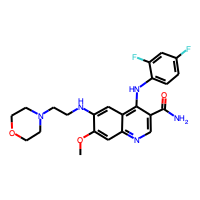
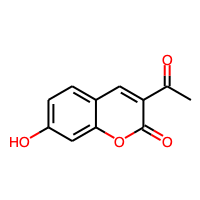
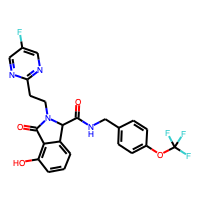
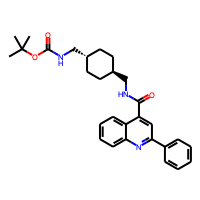
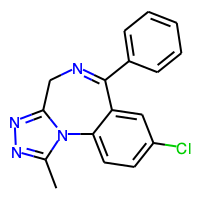
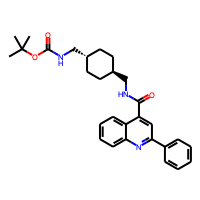
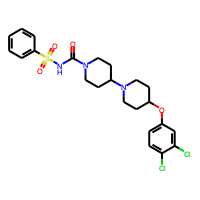
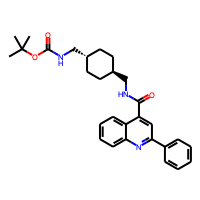
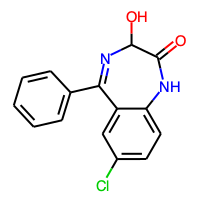
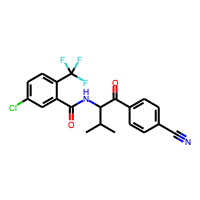
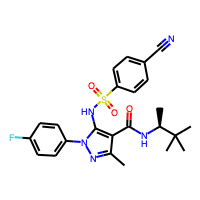
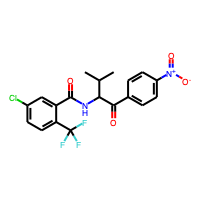
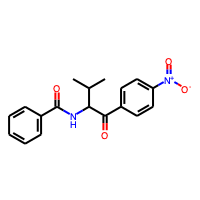
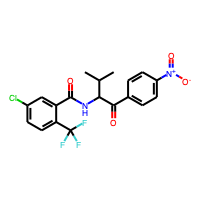
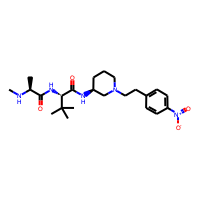
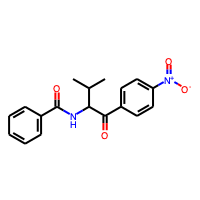
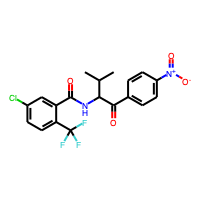
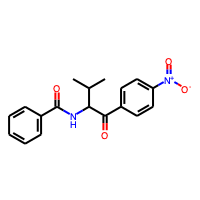
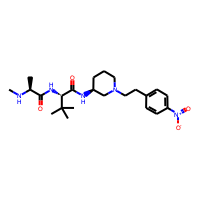
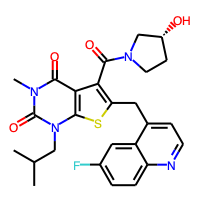
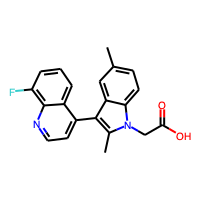
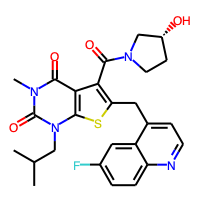
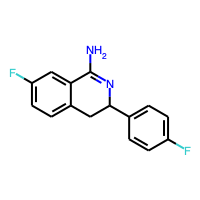
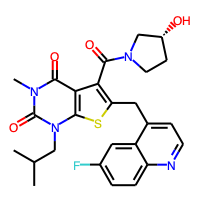
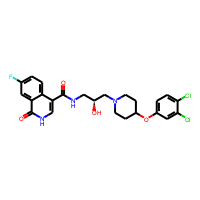
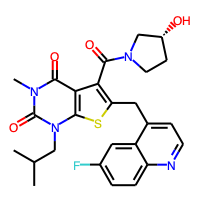
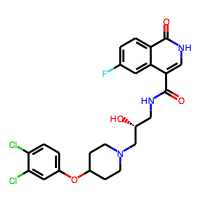
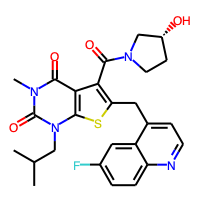
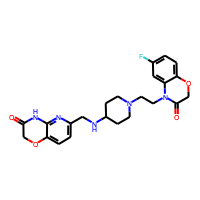
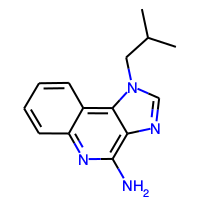
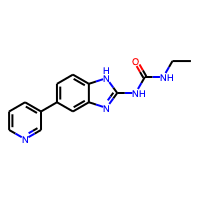
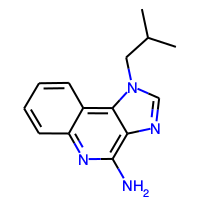
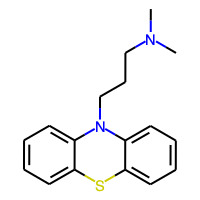
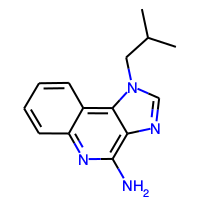
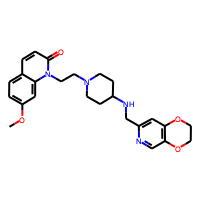
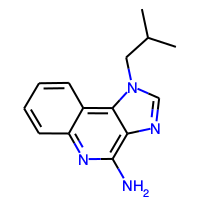
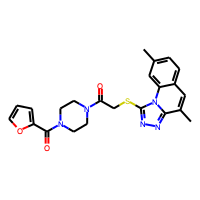
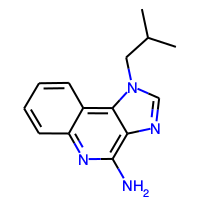
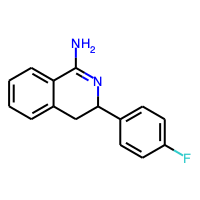
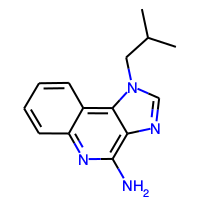
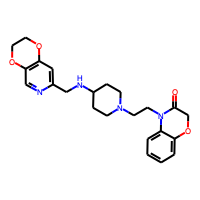
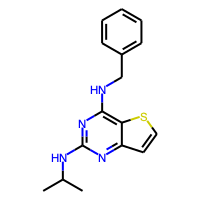
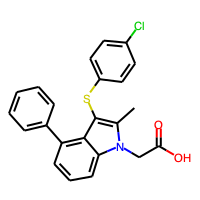
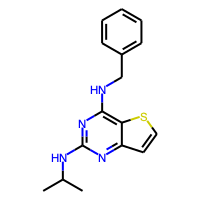
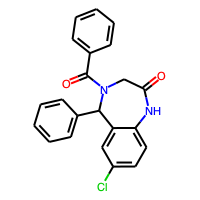
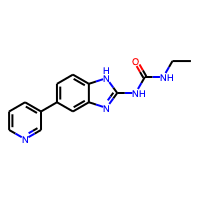
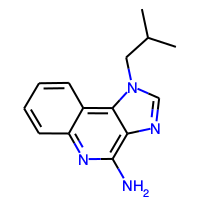
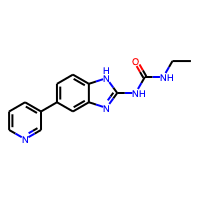
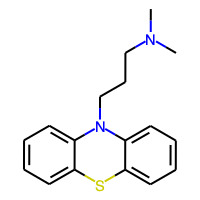
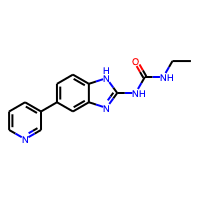
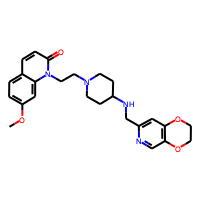
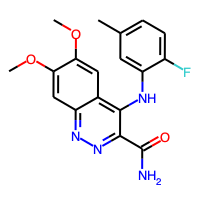
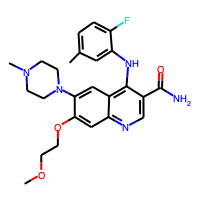
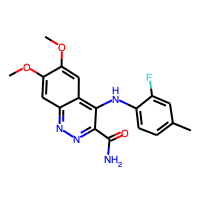
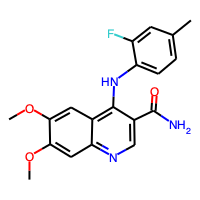
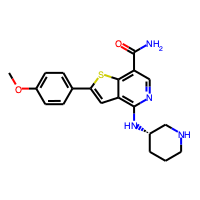
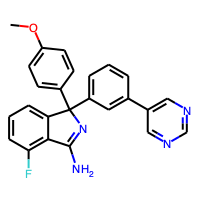
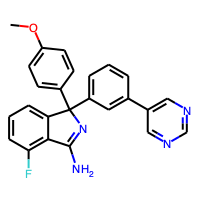
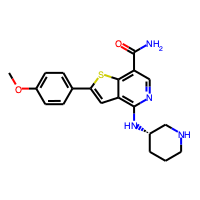
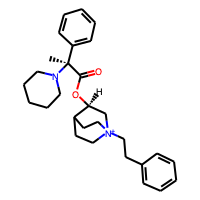
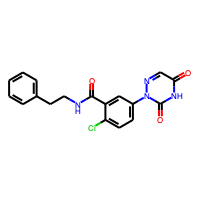
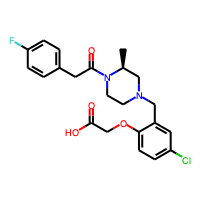
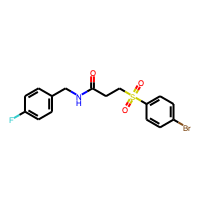
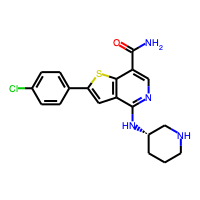
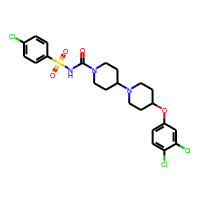
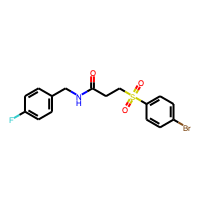
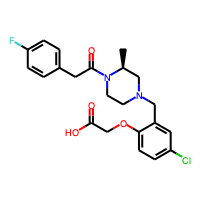
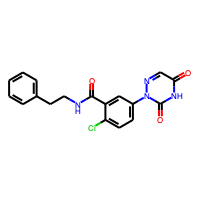
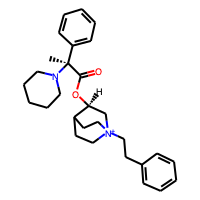
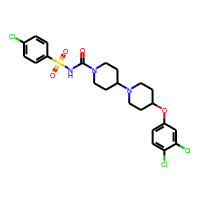
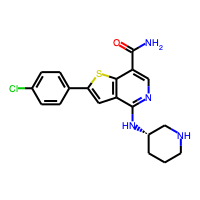
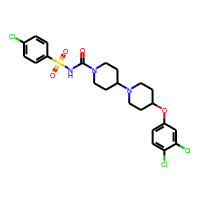
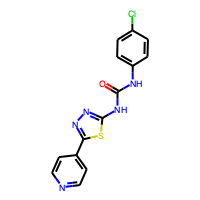
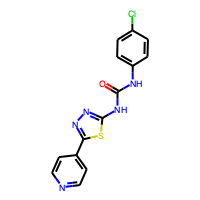
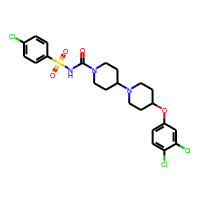
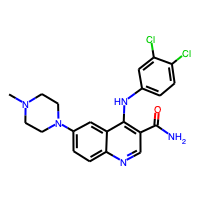
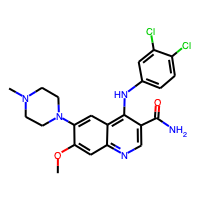
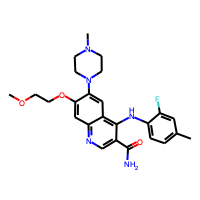
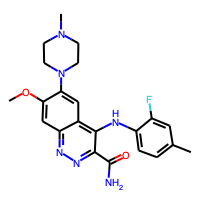
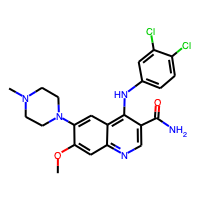
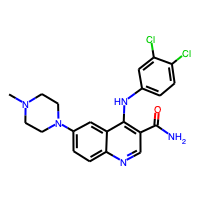
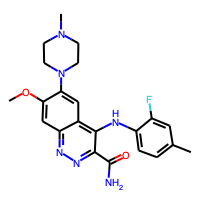
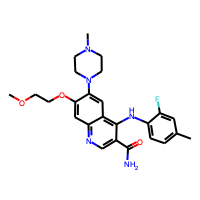
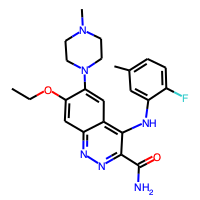
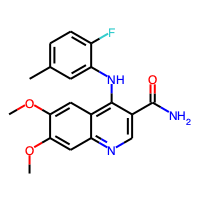
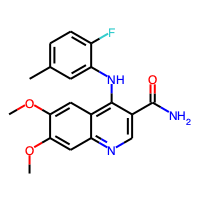
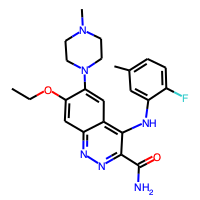
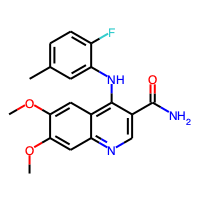
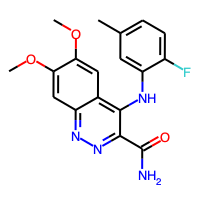
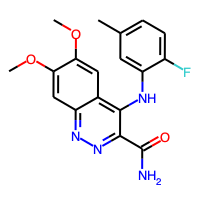
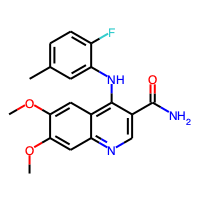
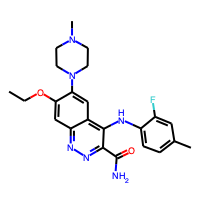
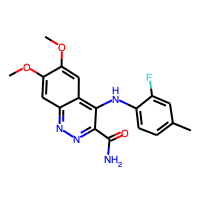
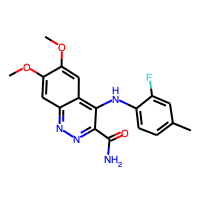
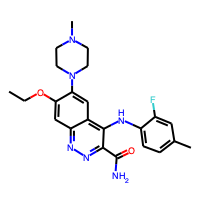
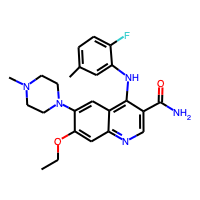
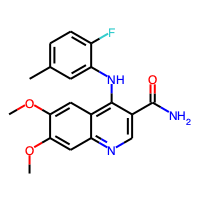
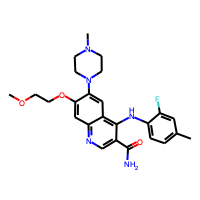
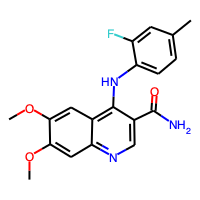
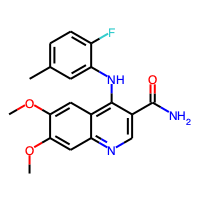
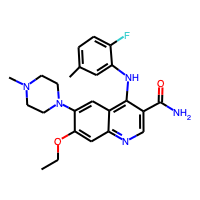
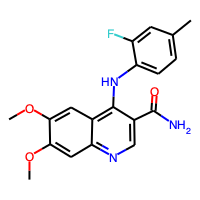
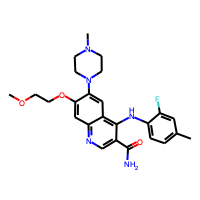
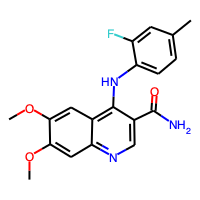
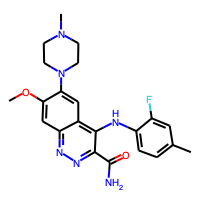
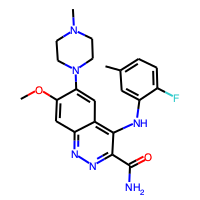
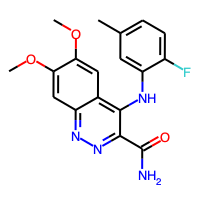
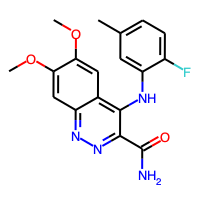
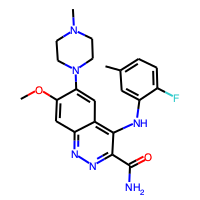
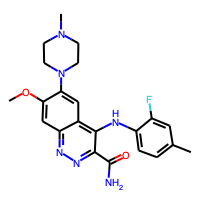
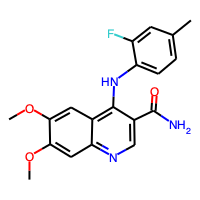

In [15]:
df.head(250)

### Degree - Number of fragments per compound node

In [16]:
#Run
data = graph_1.run("""
                CALL gds.alpha.degree.stream('fragsimgraph')
                YIELD nodeId, score
                RETURN gds.util.asNode(nodeId).smiles AS Compound1, gds.util.asNode(nodeId).compoundid as CID, score AS degree
                ORDER BY degree DESC
                """).data()

In [130]:
#Write
data = graph_1.run("""
                CALL gds.alpha.degree.write('fragsimgraph',{writeProperty: 'fragment_degree'})
                YIELD nodes, writeProperty
                """).data()

### Degree - Number of compounds per fragment node

In [60]:
data = graph_1.run("""
                CALL gds.alpha.degree.stream('fragsimgraph_c')
                YIELD nodeId, score
                RETURN gds.util.asNode(nodeId).smiles AS Fragment1, gds.util.asNode(nodeId).fragmentid as FID, score AS degree
                ORDER BY degree DESC
                """).data()

In [58]:
data = graph_1.run("""
                CALL gds.alpha.degree.write('fragsimgraph_c',{writeProperty: 'compound_degree'})
                YIELD nodes, writeProperty
                """).data()

### Degree - Number of fragments per fragment node

In [76]:
data = graph_1.run("""
                CALL gds.alpha.degree.stream('fraggraph_2')
                YIELD nodeId, score
                RETURN gds.util.asNode(nodeId).smiles AS Fragment1, gds.util.asNode(nodeId).fragmentid as FID, score AS degree
                ORDER BY degree DESC
                """).data()

In [65]:
data = graph_1.run("""
                CALL gds.alpha.degree.write('fraggraph_2',{writeProperty: 'frag_frag_degree'})
                YIELD nodes, writeProperty
                """).data()

In [77]:
pd.DataFrame(data).head()

,FID,Fragment1,degree
0,15,[*:1]C,677.0
1,2209,[*:1]Br,204.0
2,2106,[*:1]F,201.0
3,1286,[*:1]C(C)C,199.0
4,2122,[*:1]Cl,198.0


### Find me similar compounds based on their fragments

In [265]:
data = graph_1.run("""MATCH (n:Compound)-[m]-(p)
                      WHERE n.fragment_degree>=3
                      AND m.similarity_score IS NOT null
                      AND startnode(m) = n
                      RETURN
                             DISTINCT n.compoundid AS cid1, n.smiles AS Compound1, n.fragment_degree,
                             p.compoundid AS cid2, p.smiles AS Compound2, p.fragment_degree, 
                             m.similarity_score
                      ORDER BY m.similarity_score DESC""").data()

In [266]:
df = pd.DataFrame(data)

In [267]:
PandasTools.AddMoleculeColumnToFrame(df, 'Compound1','Compound1')
PandasTools.AddMoleculeColumnToFrame(df, 'Compound2','Compound2')

,Compound1,Compound2,cid1,cid2,m.similarity_score,n.fragment_degree,p.fragment_degree
0,,,307,311,1.0,17.0,17.0
1,,,310,312,1.0,15.0,15.0
2,,,311,307,1.0,17.0,17.0
3,,,312,310,1.0,15.0,15.0
4,,,578,580,1.0,3.0,3.0

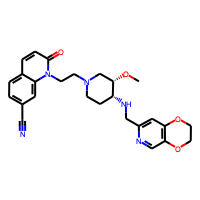
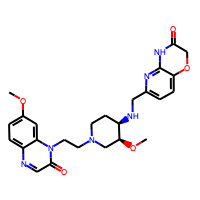
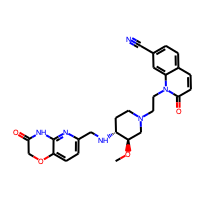
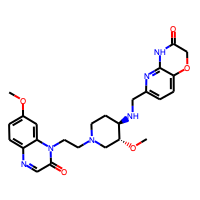
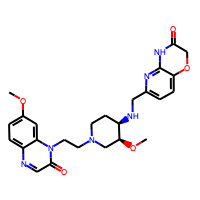
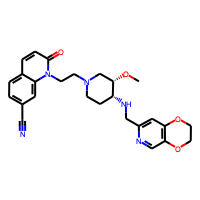
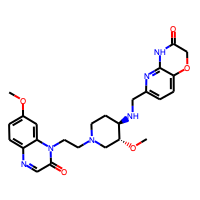
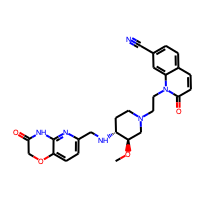
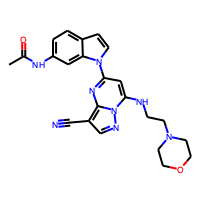
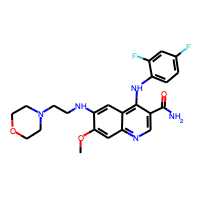

In [270]:
df.head()

### Find me fragments which are important, based on their place in the fragment network, weighted by avg MMP change - maybe these are the ones that get changed the most frequently?

In [305]:
data = graph_1.run("""
                CALL gds.pageRank.write('fraggraph', {relationshipWeightProperty:'avg', writeProperty:'fragment_pageRank'})
                """).data()

In [309]:
data = graph_1.run("""
                CALL gds.pageRank.write('fraggraph', {writeProperty:'fragment_pageRank_unweighted'})
                """).data()

In [131]:
data = graph_1.run("""
                MATCH (n:Fragment)
                WHERE EXISTS(n.fragment_pageRank)
                RETURN n.smiles as smiles, n.fragment_pageRank as fragment_pageRank, n.fragment_pageRank_unweighted, n.compound_degree, n.frag_frag_degree,
                       n.unique_fragment_count
                ORDER by n.fragment_pageRank DESC
                """).data()

In [132]:
df = pd.DataFrame(data)
#PandasTools.AddMoleculeColumnToFrame(df, 'n.smiles','Fragment')

In [133]:
df.head(10)

,fragment_pageRank,n.compound_degree,n.frag_frag_degree,n.fragment_pageRank_unweighted,n.unique_fragment_count,smiles
0,4.114433,37.0,102.0,3.780301,56,[*:1]c1ccccc1
1,3.499296,142.0,0.0,7.118977,56,[*:1][H]
2,2.378116,9.0,78.0,2.102223,41,[*:1]NC(C)=O
3,2.195371,1.0,6.0,0.635886,8,[*:1]c1ccccc1N(C)C
4,2.032635,3.0,18.0,0.329875,6,[*:1]NS(C)(=O)=O
5,1.902379,3.0,0.0,1.547490,11,[*:1]c1ccccc1OC
6,1.580521,13.0,18.0,1.808952,24,[*:1]c1ccccc1[*:2]
7,1.499931,1.0,0.0,0.806513,6,[*:1][C@@H]1CCCc2ccccc21
8,1.493443,1.0,0.0,0.735985,2,[*:1]c1ccccc1N([*:2])C
9,1.467752,5.0,6.0,1.938062,18,[*:1]c1ccco1


In [25]:
data = graph_1.run("""
                MATCH (n:Fragment)
                WHERE n.smiles = "[*:1]c1ccccc1"
                RETURN n.smiles, count(n) as count
                """).data()

In [26]:
data

[{'n.smiles': '[*:1]c1ccccc1', 'count': 1}]

In [ ]:
MATCH (n:Fragment)-[r:MMP_RULE_ENVIRONMENT]-(q:Fragment)
WITH n.fragmentid as id, count(distinct(q)) as unique_node_count, n.smiles as smiles
MATCH (n:Fragment)
WHERE n.fragmentid = id 
SET n.unique_fragment_count=unique_node_count

In [139]:
import seaborn as sns

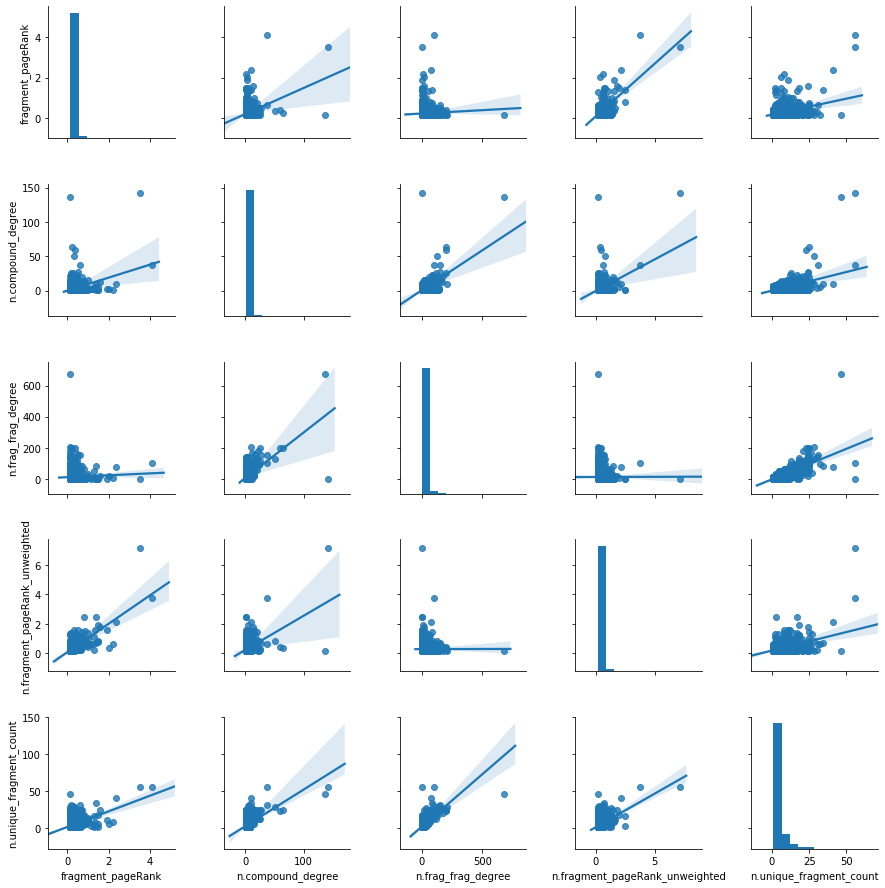

In [146]:
sns.pairplot(df, kind="reg")

In [2]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from sklearn.linear_model import LinearRegression
from bokeh.models import Slope
output_notebook()

Loading BokehJS ...

In [3]:
p = figure()
p.circle(x='n.unique_fragment_count', y='n.frag_frag_degree',
         source=df,
         size=10, color='blue')

hover = HoverTool()
hover.tooltips=[
    ('smiles', '@smiles'),
    ('fragment_pageRank', '@fragment_pageRank')
]

p.add_tools(hover)

show(p)

NameError: name 'df' is not defined

## Link prediction

* It's not useful to predict links between compounds here... i.e. which compounds will be MMP of each other... compounds are either MMP or they are not...

* Instead what is more useful is to predict whether FRAGMENTS will be related (i.e. will changing one fragment for another change a property I am interested in?)

### We can use Adamic Agar for this
* This will tell us the likelyhood of a relationship between two fragments. Most likely it will give us the fragments which are commonly exhanged with each other but are not represented in the data through a direct MMP.
* What it does not tell us is the size of that property or even what property... to do this we'll need more advanced algos that can account for more features of nodes and relationships.

In [ ]:
MATCH (f1:Fragment), (f2:Fragment)
WHERE NOT (f1)-[:MMP_RULE_ENVIRONMENT]-(f2)
AND f1.compound_degree > 10
AND f2.compound_degree > 10
RETURN gds.alpha.linkprediction.adamicAdar(f1, f2) AS score, f1.smiles, f2.smiles, f1.compound_degree, f1.fragmentid as fid1, f2.fragmentid as fid2
ORDER BY score DESC